### **PINN Exercise!**

Solve the following problem with a PINN
$$
\begin{cases}
- u'' = \sin(\pi x) & \text { in } (0,2),\\
u(0) = u(2) = 0.  
\end{cases}
$$
Take inspiration from the exercises we have done in class.

In this case, the exact solution is
$$
u(x) = \frac{1}{\pi^2}\sin(\pi x).
$$

In [ ]:
#### starting stuff ####

import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(1,5)
        self.hidden_layer1 = nn.Linear(5,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x):
        input = x
        layer1_out = torch.sigmoid(self.input_layer(input))
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))
        output = self.output_layer(layer5_out)
        return output

In [ ]:
### (2) Model
seed = 0
torch.manual_seed(seed)
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

In [ ]:
## PDE as loss function. Thus would use the network which we call as u_theta
def R(x, net):
    u = net(x) # the dependent variable u is given by the network based on independent variables x,t
    
    ## Based on our R = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    
    f = torch.Tensor(np.sin(3.14*x.detach().numpy()))
    pde = -u_xx - f
    
    return pde

In [ ]:
## Data from Boundary Conditions
# u(x,0)=6e^(-3x)
## BC just gives us datapoints for training

# BC tells us that for any x in range[0,2] and time=0, the value of u is given by 6e^(-3x)
# Take say 500 random numbers of x
x_bc = np.zeros((2,1))
x_bc[1] = 2;
# t_bc = np.zeros((500,1))
# compute u based on BC
u_bc = np.zeros((2,1))


In [ ]:
### (3) Training / Fitting
iterations = 10000
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False)
    net_bc_out = net(pt_x_bc) # output of u(x)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
    all_zeros = np.zeros((500,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)
    f_out = R(pt_x_collocation, net) # output of R(x)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_f + mse_u
    
    
    loss.backward() 
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch,"Loss:",loss.item())

Output streaming troncato alle ultime 5000 righe.
5000 Loss: 0.012094208039343357
5001 Loss: 0.010696147568523884
5002 Loss: 0.009584775194525719
5003 Loss: 0.01118736993521452
5004 Loss: 0.008866455405950546
5005 Loss: 0.01160397008061409
5006 Loss: 0.010952768847346306
5007 Loss: 0.011725068092346191
5008 Loss: 0.011162648908793926
5009 Loss: 0.012054170481860638
5010 Loss: 0.010277891531586647
5011 Loss: 0.011736045591533184
5012 Loss: 0.00915398821234703
5013 Loss: 0.010347770527005196
5014 Loss: 0.009234733879566193
5015 Loss: 0.00961947999894619
5016 Loss: 0.01053347997367382
5017 Loss: 0.010235223919153214
5018 Loss: 0.009005125612020493
5019 Loss: 0.011181368492543697
5020 Loss: 0.008715793490409851
5021 Loss: 0.011449373327195644
5022 Loss: 0.009536373429000378
5023 Loss: 0.011301516555249691
5024 Loss: 0.01279364712536335
5025 Loss: 0.010175935924053192
5026 Loss: 0.012781191617250443
5027 Loss: 0.00905542355030775
5028 Loss: 0.010510429739952087
5029 Loss: 0.0092671019956469

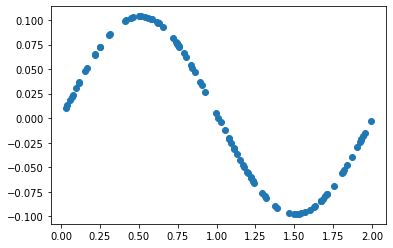

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

x=np.random.uniform(low=0.0, high=2.0, size=(100,1))

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True)
pt_u = net(pt_x)
u=pt_u.data.cpu().numpy()
plt.scatter(x, u)
plt.show()

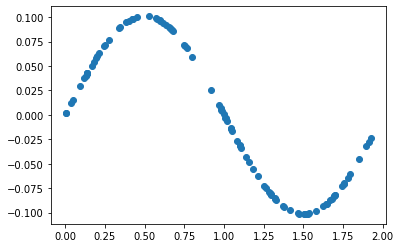

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

x=np.random.uniform(low=0.0, high=2.0, size=(100,1))

u=np.sin(np.pi*x)*(1/(np.pi**2))
plt.scatter(x, u)
plt.show()

To impose *directly* the boundary conditions (usually gives better training results) you have to: 
* impose the condition directly on the output of the forward law multiplying the output by a function that does the job!
In our case: to make the solution zero at $x = 0$ and $x = 2$, a good function is $x(x - 2)$. Thus ``x*(x - 2)*output``.
* Get rid of the Dirichlet cost: it is not needed anymore :)